# Compression Pipeline:


<div style="background-color: white; padding: 10px;">
    <img src="./docs/static/img/pipeline.svg" alt="SVG Image" width="1500px" />
</div>

Instead of running the compression pipeline all at once, here you can run it step-by-step and explore the process.

## First simulate the command-line arguments

In [1]:
simulated_args = [
        "--model_path", "./input_models/flower_hq",
        "--data_device", "cuda",
        "--output_vq", "./output"
]

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import time

from argparse import ArgumentParser
from arguments import (
    CompressionParams,
    ModelParams,
    OptimizationParams,
    PipelineParams,
    get_combined_args,
)

from compress import unique_output_folder, calc_importance
from gaussian_renderer import GaussianModel
from scene import Scene

In [3]:
def parse_arguments(simulated_args=[]):
    # Initialize the argument parser
    parser = ArgumentParser(description="Compression script parameters")
    
    # Add the same argument groups as in the script
    model = ModelParams(parser, sentinel=True)
    model.data_device = "cuda"
    pipeline = PipelineParams(parser)
    op = OptimizationParams(parser)
    comp = CompressionParams(parser)
    
    # Combine simulated args with parser arguments
    args = get_combined_args(parser, simulated_args)
    return args, model, pipeline, op, comp


args, model, pipeline, op, comp = parse_arguments(simulated_args)

# Set output folder if not specified
if args.output_vq is None:
    args.output_vq = unique_output_folder()

# Extract parameters
model_params = model.extract(args)
optim_params = op.extract(args)
pipeline_params = pipeline.extract(args)
comp_params = comp.extract(args)

Looking for config file in ./input_models/flower_hq/cfg_args
Config file found: ./input_models/flower_hq/cfg_args


In [4]:
# Initialize the Gaussians
gaussians = GaussianModel(
    model_params.sh_degree, quantization=not optim_params.not_quantization_aware
)

# Initialize the scene (test cameras + train cameras)
scene = Scene(
    model_params, gaussians, load_iteration=comp_params.load_iteration, shuffle=True
)

# Extract the Gaussians from the pre-trained model (checkpoint)
if comp_params.start_checkpoint:
    (checkpoint_params, first_iter) = torch.load(comp_params.start_checkpoint)
    gaussians.restore(checkpoint_params, optim_params)


timings ={}

Loading trained model at iteration 30000
Reading camera 173/173
Loading Training Cameras
Loading Test Cameras


## Step 1: Parameter Sensitivity
Note: The authors use 'sensitivity' and 'importance' interchangeably, this is very confusing I know 

In [5]:
start_time = time.time()

color_importance, gaussian_sensitivity = calc_importance(
    gaussians, scene, pipeline_params
)
end_time = time.time()
timings["sensitivity_calculation"] = end_time-start_time

Calculating sensitivity: 100%|██████████| 173/173 [00:05<00:00, 31.38it/s]


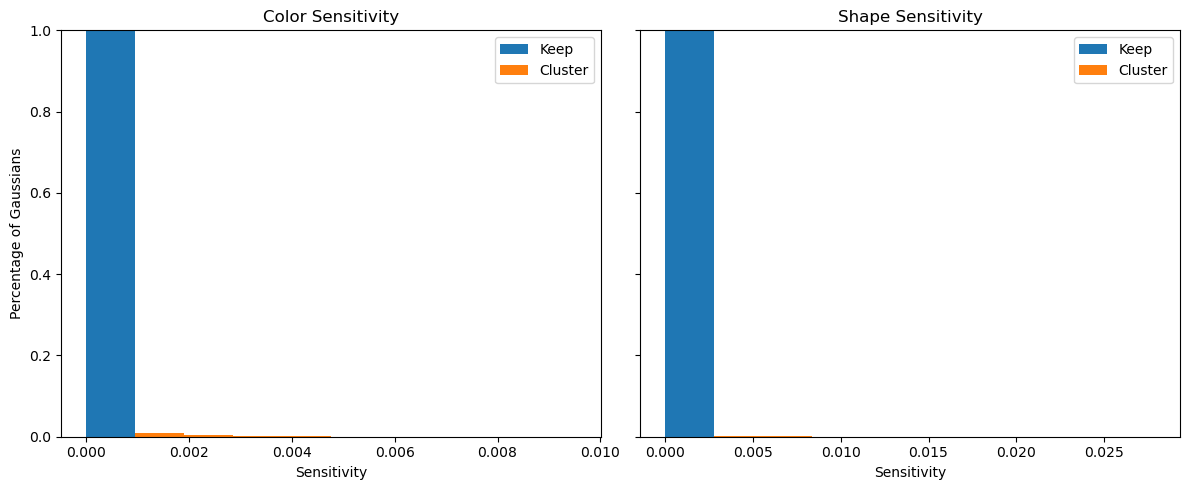

In [26]:
threshold = 0.95
color_threshold = torch.quantile(color_importance, threshold)
gaussian_threshold = torch.quantile(gaussian_sensitivity, threshold)

# Histogram bins
num_bins = 10

# Bin data based on threshold to separate "Keep" and "Cluster"
color_keep = color_importance[color_importance <= color_threshold]
color_cluster = color_importance[color_importance > color_threshold]
gaussian_keep = gaussian_sensitivity[gaussian_sensitivity <= gaussian_threshold]
gaussian_cluster = gaussian_sensitivity[gaussian_sensitivity > gaussian_threshold]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Color sensitivity histogram
axes[0].hist(
    [color_keep.cpu().numpy(), color_cluster.cpu().numpy()],
    bins=num_bins,
    stacked=True,
    label=["Keep", "Cluster"],
    color=["#1f77b4", "#ff7f0e"],
    weights=[np.ones(len(color_keep)) / len(color_importance),
             np.ones(len(color_cluster)) / len(color_importance)]
)
axes[0].set_title("Color Sensitivity")
axes[0].set_xlabel("Sensitivity")
axes[0].set_ylabel("Percentage of Gaussians")
axes[0].set_ylim(0, 1)
axes[0].legend()

# Shape sensitivity histogram
axes[1].hist(
    [gaussian_keep.cpu().numpy(), gaussian_cluster.cpu().numpy()],
    bins=num_bins,
    stacked=True,
    label=["Keep", "Cluster"],
    color=["#1f77b4", "#ff7f0e"],
    weights=[np.ones(len(gaussian_keep)) / len(gaussian_sensitivity),
             np.ones(len(gaussian_cluster)) / len(gaussian_sensitivity)]
)
axes[1].set_title("Shape Sensitivity")
axes[1].set_xlabel("Sensitivity")
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()

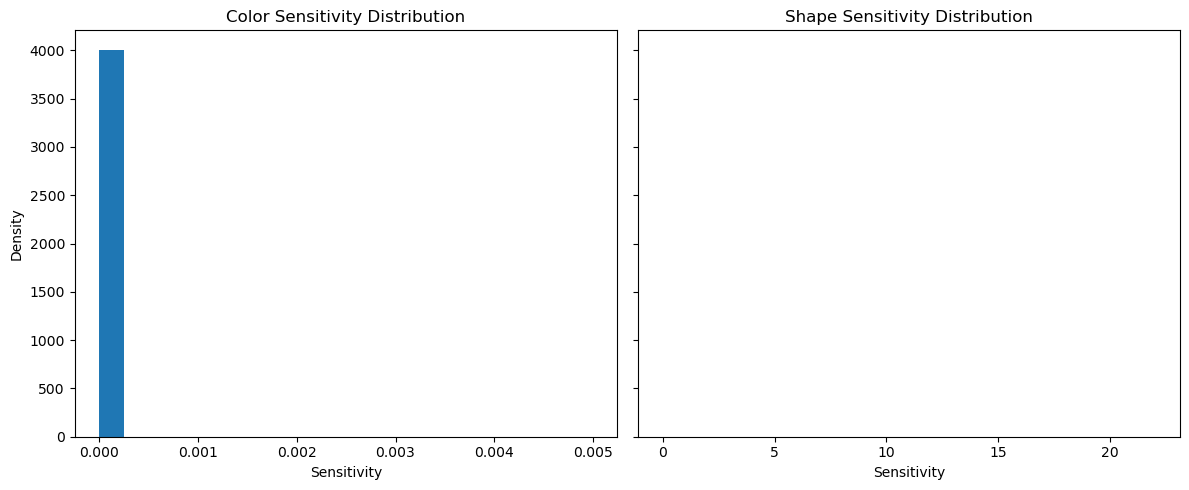

In [6]:
color_importance = color_importance.cpu().numpy().flatten()  # Convert to numpy array if needed
gaussian_sensitivity = gaussian_sensitivity.cpu().numpy().flatten()

# color_importance = color_importance.flatten()
# gaussian_sensitivity = gaussian_sensitivity.flatten()

# Define the number of bins
num_bins = 20

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Color sensitivity histogram
axes[0].hist(
    color_importance,
    bins=num_bins,
    color="#1f77b4",
    density=True
)
axes[0].set_title("Color Sensitivity Distribution")
axes[0].set_xlabel("Sensitivity")
axes[0].set_ylabel("Density")

# Shape sensitivity histogram
axes[1].hist(
    gaussian_sensitivity,
    bins=num_bins,
    color="#ff7f0e",
    density=True
)
axes[1].set_title("Shape Sensitivity Distribution")
axes[1].set_xlabel("Sensitivity")

plt.tight_layout()
plt.show()